<a href="https://colab.research.google.com/github/cpappas18/articulaite/blob/main/K_NN_Classification_(all_datasets_median_remove).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from os import system
from collections import Counter
from imblearn.over_sampling import SMOTE
from numpy import where, random
!pip install scikit-multilearn

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


     |████████████████████████████████| 92kB 2.3MB/s 


In [ ]:
data = pd.read_csv('all_disorders_median_std.csv')
data2=pd.read_csv('all_disorders_remove_std.csv')

In [ ]:
def smote_multiclass(df, num_samples_dict=None, one_hot_encoded=False):
  """
  Performs data augmentation and/or downsampling on a dataframe with multiple classes.
  Supports both numerical and one-hot encoded class values.
  The SMOTE algorithm is used for augmentation and random sampling is used for downsampling of the specified classes.
  Keyword arguments:
  df -- the dataframe to manipulate
  num_samples_dict -- a dictionary of the form {0: num_desired_samples, 1: num_desired_samples, ...} that indicates the
                      number of samples that the returned dataframe should have in each class
  one_hot_encoded -- Boolean value indicating if the dataframe is one-hot encoded
  """

  if df.columns[[0]] == 'Unnamed: 0':
    df.drop(df.columns[[0]], axis=1, inplace=True)  # remove first column

  # change one hot encoded dataset into numerical labels
  if one_hot_encoded:
    df.insert(loc=0, column='Status', value=np.nan)
    for i, row in df.iterrows():
      if df.iloc[i]['Control'] == 1:
          status = 0
      elif df.iloc[i]['Parkinsons'] == 1:
          status = 1
      elif df.iloc[i]['ALS'] == 1:
          status = 2
      elif df.iloc[i]['Cerebral_palsy'] == 1:
          status = 3
      df.at[i,'Status'] = status
    df = df.drop(columns=['Control', 'Parkinsons', 'ALS', 'Cerebral_palsy'])


  if num_samples_dict is not None:
    strategy = num_samples_dict

    # downsampling classes if needed
    counter = Counter(df.Status)
    class_samples = []
    for i in range(4):
      if counter[i] > num_samples_dict[i]: # class i needs to be downsampled
        class_i = df.loc[df['Status'] == i]
        class_i_sample = class_i.sample(n=num_samples_dict[i])
        class_samples.append(class_i_sample)
      else: # class i does not need downsampling
        class_i = df.loc[df['Status'] == i]
        class_samples.append(class_i)

    df = pd.concat(class_samples).reset_index(drop=True)

  else:
    strategy = 'auto'

  y = df.Status # labels
  x = df.drop(['Status', 'Gender'], axis=1) # features only, Gender also removed because it must be binary
  gender = df.Gender

  oversample = SMOTE(sampling_strategy=strategy)
  x_oversampled, y_oversampled = oversample.fit_resample(x, y)

  # get sample counts for augmented dataset
  counter = Counter(y_oversampled)

  if num_samples_dict is not None and (counter[0] != num_samples_dict[0] or counter[1] != num_samples_dict[1]
                                       or counter[2] != num_samples_dict[2] or counter[3] != num_samples_dict[3]):
    print("Sampling failed")
  elif num_samples_dict is None and (counter[0] != counter[1] or counter[1] != counter[2] or counter[2] != counter[3]):
    print("Sampling failed")

  # regenerate dataframe with new samples
  df_concat = pd.concat([pd.DataFrame(y_oversampled), pd.DataFrame(gender), pd.DataFrame(x_oversampled)], axis=1)
  df_concat.columns = df.columns

  # fill missing gender values with a random choice of 0 or 1
  for row in df_concat.loc[df_concat.Gender.isnull(), 'Gender'].index:
    df_concat.at[row, 'Gender'] = random.randint(0, 2)

  # change numerical class values back into one-hot encoded values
  if one_hot_encoded:
    one_hot = pd.get_dummies(df_concat['Status'])
    one_hot.rename(columns={0:'Control', 1:'Parkinsons', 2:'ALS', 3:'Cerebral_palsy'}, inplace=True)
    df_concat = df_concat.drop(columns=['Status'], axis=1)
    df_concat = pd.concat([one_hot, df_concat], axis=1)

  return df_concat, x, y

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

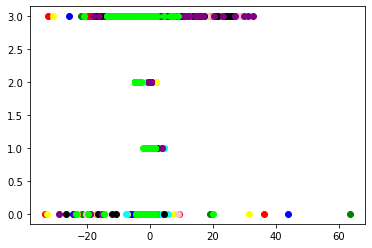

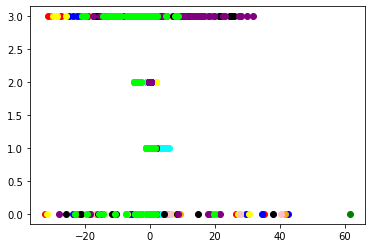

In [ ]:
data, x, y = smote_multiclass(data, num_samples_dict={0: 200, 1: 180, 2: 150, 3:60},one_hot_encoded=False)
data2, x2, y2 = smote_multiclass(data2, num_samples_dict={0: 200, 1: 180, 2: 150, 3:60},one_hot_encoded=False)
#Visualizing data distribution for data 1
plt.scatter(x['MDVP:Jitter(%)'],y,color='red')
plt.scatter(x['MDVP:Jitter(Abs)'],y,color='green')
plt.scatter(x['Jitter:PPQ5'],y,color='blue')
plt.scatter(x['Jitter:DDP'],y,color='yellow')
plt.scatter(x['MDVP:Shimmer'],y,color='orange')
plt.scatter(x['MDVP:Shimmer(dB)'],y,color='cyan')
plt.scatter(x['Shimmer:APQ3'],y,color='pink')
plt.scatter(x['Shimmer:APQ5'],y,color='black')
plt.scatter(x['Shimmer:APQ11'],y,color='purple')
plt.scatter(x['DFA'],y,color='lime')
plt.show()

#Visualizing data distribution for data 2
plt.scatter(x2['MDVP:Jitter(%)'],y2,color='red')
plt.scatter(x2['MDVP:Jitter(Abs)'],y2,color='green')
plt.scatter(x2['Jitter:PPQ5'],y2,color='blue')
plt.scatter(x2['Jitter:DDP'],y2,color='yellow')
plt.scatter(x2['MDVP:Shimmer'],y2,color='orange')
plt.scatter(x2['MDVP:Shimmer(dB)'],y2,color='cyan')
plt.scatter(x2['Shimmer:APQ3'],y2,color='pink')
plt.scatter(x2['Shimmer:APQ5'],y2,color='black')
plt.scatter(x2['Shimmer:APQ11'],y2,color='purple')
plt.scatter(x2['DFA'],y2,color='lime')
plt.show()

In [ ]:
'''Splitting Data for median dataset'''
# Splitting Data into 70% Training data and 30% Testing Data:
X_train, X_test, y_train,  y_test = train_test_split(x, y,train_size=0.7, test_size=0.3, random_state=42,stratify=y)
print(f"X_test length is {len(X_test)}.")
print(f"Y_test length is {len(y_test)}.")
print(f"X_train length is {len(X_train)}.")
print(f"Y_train length is {len(y_train)}.")

#Seeing the number/percentage of the split
s=np.unique(y_train, return_counts=True)
print()
print(f"The split is as follows:{s}")
print()

'''Splitting Data for remove dataset'''
# Splitting Data into 70% Training data and 30% Testing Data:
X_train2, X_test2, y_train2,  y_test2 = train_test_split(x2, y2,train_size=0.7, test_size=0.3, random_state=42,stratify=y2)
print(f"X_test2 length is {len(X_test2)}.")
print(f"Y_test2 length is {len(y_test2)}.")
print(f"X_train2 length is {len(X_train2)}.")
print(f"Y_train2 length is {len(y_train2)}.")

#Seeing the number/percentage of the split
s2=np.unique(y_train2, return_counts=True)
print()
print(f"The split is as follows:{s2}")

X_test length is 177.
Y_test length is 177.
X_train length is 413.
Y_train length is 413.

The split is as follows:(array([0, 1, 2, 3]), array([140, 126, 105,  42]))

X_test2 length is 177.
Y_test2 length is 177.
X_train2 length is 413.
Y_train2 length is 413.

The split is as follows:(array([0, 1, 2, 3]), array([140, 126, 105,  42]))


# K-Nearest Neighbor Classification

In [ ]:
'''k-NN for Median Dataset'''
#k-NN
from sklearn.neighbors import KNeighborsClassifier
#To use the build in multilabel adabtor use:
#from skmultilearn.adapt import MLkNN
#knn_model= MLkNN(k=20)

#fiting training data on model
#Setup arrays to store training and test accuracies
neighbors = np.arange(1,9)
train_accuracy =np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i,k in enumerate(neighbors):
    #Setup a knn classifier with k neighbors
    knn_model = KNeighborsClassifier(n_neighbors=k)
    
    #Fit the model
    knn_model.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn_model.score(X_train, y_train)
    
    #Compute accuracy on the test set
    test_accuracy[i] = knn_model.score(X_test, y_test) 
    print(f"Train Accuracy:")
    print(train_accuracy[i])
    print(f"Test Accuracy:")
    print(test_accuracy[i])

#prediction using K-NN
y_pred = knn_model.predict(X_test)
print(f"The predictions for the data is {y_pred}")

#Looking at accuracy by counting the number of misclassified cases
count_misclassified = (y_test != y_pred).sum()
print('Misclassified samples in KNN: {}'.format(count_misclassified))

#Mean Square Error
from sklearn.metrics import mean_squared_error
from math import sqrt
train_preds = knn_model.predict(X_train)
mse = mean_squared_error(y_train, train_preds)
rmse1 = sqrt(mse)
print(f"Mean square error for training data is {rmse1}")

#evaluating the predictive performance of our model
test_preds = knn_model.predict(X_test)
mse = mean_squared_error(y_test, test_preds)
rmse2 = sqrt(mse)
print(f"Mean square error for test data is {rmse2}")

Train Accuracy:
1.0
Test Accuracy:
0.7909604519774012
Train Accuracy:
0.9128329297820823
Test Accuracy:
0.7853107344632768
Train Accuracy:
0.9176755447941889
Test Accuracy:
0.7401129943502824
Train Accuracy:
0.8595641646489104
Test Accuracy:
0.7853107344632768
Train Accuracy:
0.87409200968523
Test Accuracy:
0.751412429378531
Train Accuracy:
0.8450363196125908
Test Accuracy:
0.7853107344632768
Train Accuracy:
0.8571428571428571
Test Accuracy:
0.7570621468926554
Train Accuracy:
0.8184019370460048
Test Accuracy:
0.751412429378531
The predictions for the data is [0 0 0 0 3 0 0 2 0 0 0 1 2 0 1 0 1 1 2 3 1 2 0 0 0 0 3 0 0 2 2 1 0 0 1 2 0
 0 2 2 1 1 0 1 2 0 2 2 2 3 1 0 2 1 3 0 1 0 1 2 2 0 0 1 0 1 0 1 2 0 2 2 1 0
 1 0 2 2 1 0 0 3 1 0 1 1 0 2 2 2 0 0 3 2 3 0 2 0 2 2 1 0 0 1 1 0 0 2 3 1 2
 0 0 1 1 2 0 2 0 2 0 0 0 0 1 1 1 2 1 0 0 3 0 2 2 2 1 1 0 0 2 0 0 0 0 3 2 2
 2 0 1 2 1 2 0 2 1 0 3 0 3 0 0 0 0 0 3 0 2 1 0 0 0 0 3 2 2]
Misclassified samples in KNN: 44
Mean square error for training data is 0.5

In [ ]:
'''k-NN for Remove Dataset'''
#k-NN
from sklearn.neighbors import KNeighborsClassifier
#To use the build in multilabel adabtor use:
#from skmultilearn.adapt import MLkNN
#knn_model= MLkNN(k=20)

#fiting training data on model
#Setup arrays to store training and test accuracies
neighbors2 = np.arange(1,9)
train_accuracy2 =np.empty(len(neighbors2))
test_accuracy2 = np.empty(len(neighbors2))

for i,K in enumerate(neighbors2):
    #Setup a knn classifier with k neighbors
    knn_model2 = KNeighborsClassifier(n_neighbors=K)
    
    #Fit the model
    knn_model2.fit(X_train2, y_train2)
    
    #Compute accuracy on the training set
    train_accuracy2[i] = knn_model2.score(X_train2, y_train2)
    
    #Compute accuracy on the test set
    test_accuracy2[i] = knn_model2.score(X_test2, y_test2) 
    print(f"Train Accuracy:")
    print(train_accuracy2[i])
    print(f"Test Accuracy:")
    print(test_accuracy2[i])

#prediction using K-NN
y_pred2 = knn_model2.predict(X_test2)
print(f"The predictions for the data is {y_pred2}")

#Looking at accuracy by counting the number of misclassified cases
count_misclassified2 = (y_test2 != y_pred2).sum()
print('Misclassified samples in KNN: {}'.format(count_misclassified2))

#Mean Square Error
from sklearn.metrics import mean_squared_error
from math import sqrt
train_preds2 = knn_model2.predict(X_train2)
mse2 = mean_squared_error(y_train2, train_preds2)
rmse_a = sqrt(mse2)
print(f"Mean square error for training data is {rmse_a}")

#evaluating the predictive performance of our model
test_preds2 = knn_model2.predict(X_test2)
mse2 = mean_squared_error(y_test2, test_preds2)
rmse_b = sqrt(mse2)
print(f"Mean square error for test data is {rmse_b}")

Train Accuracy:
1.0
Test Accuracy:
0.7909604519774012
Train Accuracy:
0.9297820823244553
Test Accuracy:
0.7570621468926554
Train Accuracy:
0.9007263922518159
Test Accuracy:
0.7796610169491526
Train Accuracy:
0.8789346246973365
Test Accuracy:
0.7909604519774012
Train Accuracy:
0.8765133171912833
Test Accuracy:
0.7966101694915254
Train Accuracy:
0.864406779661017
Test Accuracy:
0.7796610169491526
Train Accuracy:
0.8765133171912833
Test Accuracy:
0.7966101694915254
Train Accuracy:
0.8353510895883777
Test Accuracy:
0.768361581920904
The predictions for the data is [1 0 0 0 3 1 0 2 0 1 1 1 2 0 0 0 1 0 2 3 1 2 0 1 1 0 3 0 2 2 2 1 0 1 1 2 1
 0 2 2 0 0 0 0 2 1 2 2 2 3 1 3 2 0 3 1 1 0 0 2 2 1 0 1 0 0 0 0 2 1 1 2 0 0
 0 0 2 2 0 0 0 3 0 0 0 0 3 2 2 2 0 0 3 2 3 1 2 0 2 2 1 0 0 1 0 0 0 2 3 0 2
 0 0 1 1 2 1 2 1 2 0 0 0 0 0 1 0 2 0 1 1 3 1 2 2 2 0 1 0 0 2 0 3 0 0 3 3 2
 2 0 1 2 1 2 1 2 1 1 3 1 3 0 1 0 0 0 3 0 2 1 0 1 0 0 3 2 2]
Misclassified samples in KNN: 41
Mean square error for training data is 0

# Parameter Tuning & Model Evaluation

In [ ]:
'''K prediction for Median Dataset'''

#Predicting the best value of k 
from sklearn.model_selection import GridSearchCV
parameters = {"n_neighbors": range(1, 20)}
gridsearch = GridSearchCV(KNeighborsClassifier(), parameters)
gridsearch.fit(X_train, y_train)

#using .best_params_ to find the best performing k
print(f"The best value for k is {gridsearch.best_params_}")

#Seeing how this predicted k affects the training and testing performances
train_preds_grid = gridsearch.predict(X_train)
train_mse = mean_squared_error(y_train, train_preds_grid)
train_rmse = sqrt(train_mse)
test_preds_grid = gridsearch.predict(X_test)
test_mse = mean_squared_error(y_test, test_preds_grid)
test_rmse = sqrt(test_mse)
train_rmse

print(f"Mean square error for test data is {test_rmse}")

The best value for k is {'n_neighbors': 1}
Mean square error for test data is 0.5042194840896107


In [ ]:
'''K prediction for Remove Dataset'''

#Predicting the best value of k 
from sklearn.model_selection import GridSearchCV
parameters = {"n_neighbors": range(1, 20)}
gridsearch = GridSearchCV(KNeighborsClassifier(), parameters)
gridsearch.fit(X_train2, y_train2)

#using .best_params_ to find the best performing k
print(f"The best value for k is {gridsearch.best_params_}")

#Seeing how this predicted k affects the training and testing performances
train_preds_grid2 = gridsearch.predict(X_train2)
train_mse2 = mean_squared_error(y_train2, train_preds_grid2)
train_rmse2 = sqrt(train_mse2)
test_preds_grid2 = gridsearch.predict(X_test2)
test_mse2 = mean_squared_error(y_test2, test_preds_grid2)
test_rmse2 = sqrt(test_mse2)
train_rmse2

print(f"Mean square error for test data is {test_rmse2}")

The best value for k is {'n_neighbors': 1}
Mean square error for test data is 0.5624803825832155


Text(0, 0.5, 'Mean Error')

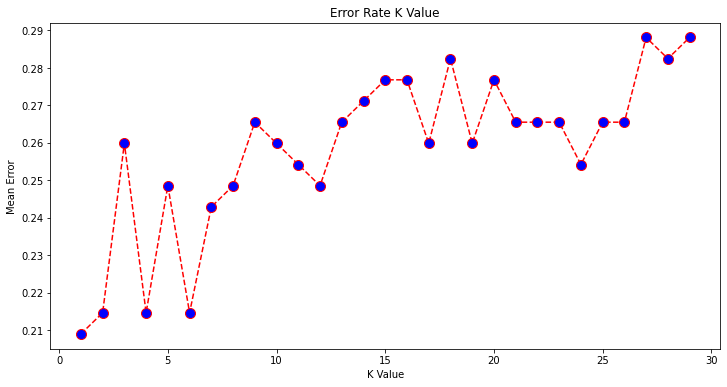

In [ ]:
error = []

# Calculating error for K values between 1 and 40 for MEDIAN DATASET
for i in range(1, 30):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))
    
# plot the error values against K values using the elbow graph method
plt.figure(figsize=(12, 6))
plt.plot(range(1, 30), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

Text(0, 0.5, 'Mean Error')

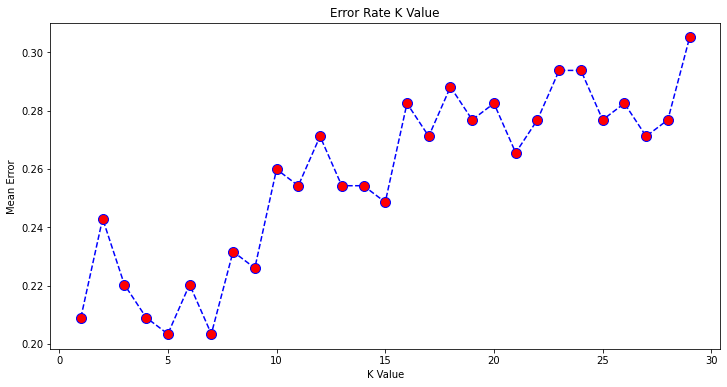

In [ ]:
error2 = []

# Calculating error for K values between 1 and 30 for REMOVE DATASET
for i in range(1, 30):
    knn2 = KNeighborsClassifier(n_neighbors=i)
    knn2.fit(X_train2, y_train2)
    pred2_i = knn2.predict(X_test2)
    error2.append(np.mean(pred2_i != y_test2))
    
# plot the error values against K values using the elbow graph method
plt.figure(figsize=(12, 6))
plt.plot(range(1, 30), error2, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

[[47 13  0  0]
 [28 26  0  0]
 [ 0  0 45  0]
 [ 1  0  2 15]]
                precision    recall  f1-score   support

       Control       0.62      0.78      0.69        60
    Parkinsons       0.67      0.48      0.56        54
           ALS       0.96      1.00      0.98        45
Cerebral Palsy       1.00      0.83      0.91        18

      accuracy                           0.75       177
     macro avg       0.81      0.77      0.78       177
  weighted avg       0.76      0.75      0.75       177



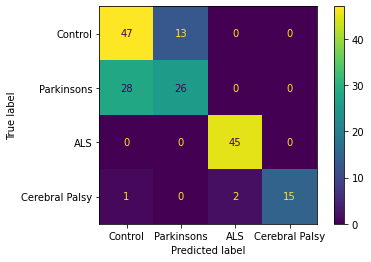

In [ ]:
'''Confusion Matrix for Remove Dataset'''
#Evaluating the Algorithm using a confusion matrix and classification report
from sklearn.metrics import classification_report, confusion_matrix
y_pred = knn_model.predict(X_test)
target_names = ['Control', 'Parkinsons', 'ALS','Cerebral Palsy']
print(confusion_matrix(y_test, y_pred))
Classification_rep=classification_report(y_test, y_pred,target_names=target_names)
print(Classification_rep)

#Plotting Confusion Matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(knn_model, X_test, y_test, display_labels=['Control', 'Parkinsons', 'ALS', 'Cerebral Palsy'])  
plt.show() 

                precision    recall  f1-score   support

       Control       0.63      0.77      0.69        60
    Parkinsons       0.71      0.54      0.61        54
           ALS       0.62      1.00      0.77         5
Cerebral Palsy       1.00      0.25      0.40         4

      accuracy                           0.66       123
     macro avg       0.74      0.64      0.62       123
  weighted avg       0.68      0.66      0.65       123



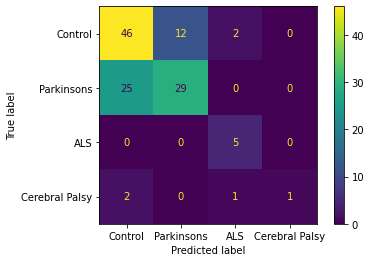

In [ ]:
'''Confusion Matrix for Remove Dataset'''
#Evaluating the Algorithm using a confusion matrix and classification report
from sklearn.metrics import classification_report, confusion_matrix
y_pred2 = knn_model2.predict(X_test2)
Classification_rep2=classification_report(y_test2, y_pred2,target_names=target_names)
print(Classification_rep2)

#Plotting Confusion Matrix for Test set
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(knn_model2, X_test2, y_test2, display_labels=['Control', 'Parkinsons', 'ALS', 'Cerebral Palsy'])  
plt.show() 



In [ ]:
'''Median Dataset'''
#Loglos Evaluation
from sklearn import model_selection
# log loss (closer to 0 is better)
for k in range(2,6,4):
  kfold = model_selection.KFold(n_splits=k, shuffle=True)
  results = model_selection.cross_val_score(knn_model, x, y, cv=kfold, scoring='neg_log_loss')
  print("Logloss: %.3f (%.f)" % (results.mean(), k))

In [ ]:
'''Remove Dataset'''
#Loglos Evaluation
from sklearn import model_selection
# log loss (closer to 0 is better)
for k in range(2,6,4):
  kfold = model_selection.KFold(n_splits=k, shuffle=True)
  results2 = model_selection.cross_val_score(knn_model2, x2, y2, cv=kfold, scoring='neg_log_loss')
  print("Logloss: %.3f (%.f)" % (results2.mean(), k))

In [ ]:
'''Median Dataset'''
#Looking at the ROC of our Model
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=2)
print(f"The False Positive Rate prediction is {fpr}")
print(f"The True Positive Rate prediction is {tpr}")
print(f"The Thresholds are {thresholds}")

In [ ]:
'''Remove Dataset'''
#Looking at the ROC of our Model
fpr2, tpr2, thresholds2 = metrics.roc_curve(y_test2, y_pred2, pos_label=2)
print(f"The False Positive Rate prediction is {fpr2}")
print(f"The True Positive Rate prediction is {tpr2}")
print(f"The Thresholds are {thresholds2}")

# Conclusion

In [ ]:
from tabulate import tabulate
print(f"Median Dataset")
print(tabulate([['Train Accuracies (k=1-9)', train_accuracy], ['Test Accuracies (k=1-9)', test_accuracy],['Data Split', s], ['Logloss', results],["Predictions", y_pred],['Number of Misclassifications',count_misclassified],['Mean Square Error for Training',rmse1],['Mean Square Error for Test',rmse2],['Classification Report',Classification_rep],['False Positive Rate', fpr], ['True positive Rate', tpr], ['Thresholds', thresholds]],headers=['Evaluations', 'Output']))

In [ ]:
print(f"Remove Dataset (Trained on Validation Set)")
print(tabulate([['Train Accuracies (k=1-9)', train_accuracy2], ['Test Accuracies (k=1-9)', test_accuracy2], ['Data Split',s2],['Logloss', results2],["Predictions", y_pred2],['Number of Misclassifications',count_misclassified2],['Mean Square Error for Training',rmse_a],['Mean Square Error for Test',rmse_b],['Classification Report',Classification_rep2],['False Positive Rate', fpr2], ['True positive Rate', tpr2], ['Thresholds', thresholds2]],headers=['Evaluations', 'Output']))

In [ ]:
import csv
import matplotlib.pyplot as plt
import os
import secrets  # to generate jpg name

def performance_report(model, X, y, X_test, y_test, y_pred, model_label):

  # classification accuracy
  try:
    from sklearn.metrics import accuracy_score
    accuracy = accuracy_score(y_test, y_pred)
  except:
    accuracy = "NA"

  # confusion matrix
  from sklearn.metrics import confusion_matrix
  from sklearn.metrics import plot_confusion_matrix

  try:
    conf = confusion_matrix(y_test, y_pred)
    TP = conf[1][1]
    TN = conf[0][0]
    FP = conf[0][1]
    FN = conf[1][0]

    disp = plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues, values_format='.0f')
    title = secrets.token_hex(4)
    plt.savefig(title, format="jpg")

    path1 = os.path.abspath(title+".jpg")
  except:
    TP = TN = FP = FN = path1 = ""

  # k-fold cross validation
  from sklearn import model_selection
  try:
    kfold = model_selection.KFold(n_splits=6, shuffle=True)
    KCV = model_selection.cross_val_score(model, X, y, cv=kfold, scoring='accuracy').mean()
  except:
    KCV = ""

  # log loss (closer to 0 is better)
  try:
    logloss = model_selection.cross_val_score(model, X, y, cv=kfold, scoring='neg_log_loss').mean()
  except:
    logloss = ""

  # AUC (1 is perfect predictions, 0.5 is as good as random)
  try:
    AUC = model_selection.cross_val_score(model, X, y, cv=kfold, scoring='roc_auc').mean()
  except:
    AUC = ""

  # precision recall curve
  from sklearn.metrics import plot_precision_recall_curve
  from sklearn.metrics import average_precision_score

  try:
    y_score = model.decision_function(X_test)
    average_precision = average_precision_score(y_test, y_score)

    disp = plot_precision_recall_curve(model, X_test, y_test)
    title = secrets.token_hex(4)  
    plt.savefig(title, format="jpg")

    path2 = os.path.abspath(title+".jpg")
  except:
    average_precision = path2 = ""

  # appending metrics to csv file
  with open('metrics.csv', 'a', newline='') as file:
    writer = csv.writer(file)
    if os.stat("metrics.csv").st_size == 0:
      writer.writerow(["Model label", "Accuracy score", "TP", "TN", "FP", "FN", "Confusion matrix file","KCV", "Log-loss", "AUC", "Average precision", "Precision-recall file"])
    writer.writerow([model_label, accuracy, TP, TN, FP, FN, path1, KCV, logloss, AUC, average_precision, path2])

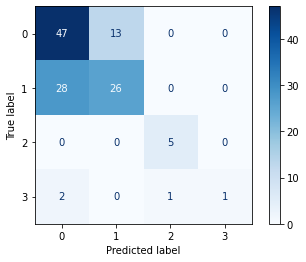

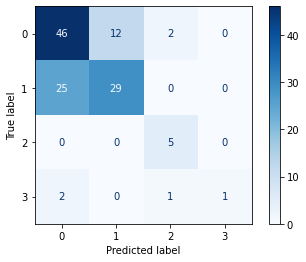

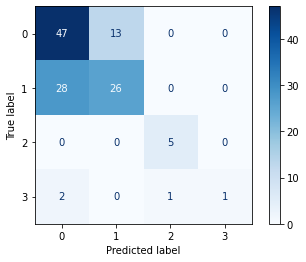

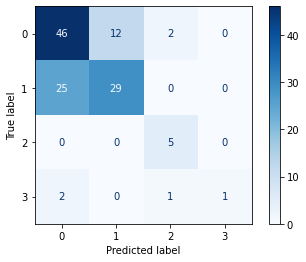

In [ ]:

# performance reports
urls = ['https://raw.githubusercontent.com/cpappas18/Dysarthria-Classifier/main/PD_remove_std_all_datasets.csv',
        'https://raw.githubusercontent.com/cpappas18/Dysarthria-Classifier/main/PD_median_std_all_datasets.csv']
titles = ['PD_remove_std_all',
          'PD_median_std_all']
for i in range(0,len(urls)):
  performance_report(knn_model, x, y, X_test, y_test, y_pred, titles[i])
  performance_report(knn_model2, x, y, X_test2, y_test2, y_pred2, titles[i])